In this notebook, I will analyze the box office data using inferential statistics, answering some questions raised 
previously when performing exploratory data analysis. 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import pearsonr
from statsmodels.stats.weightstats import ztest
from statsmodels.graphics.gofplots import qqplot

Because this dataset has multiple genres per movie, some manipulation is required in order to have a more accurate 
count of the number of genres present in the dataset, as well as to allow us to limit our analysis to the most 
popular genres (for the purposes of simplicity.)

In [91]:
# Import scraped data
df = pd.read_csv('domestic_boxoffice.csv', encoding='latin-1')  

# Trimming datbase to only contain known genres
known_genres = df[df['Genre'].str.contains('Unknown') == False].reset_index(drop=True)
genre_count = known_genres.groupby(by='Genre').size()
genre_count = genre_count.reset_index(level=[0])
genre_count.columns = ['Genre', 'Count']

# Dataset to visualize counts of each movie genre
cleaned = known_genres.set_index('Title').Genre.str.split(' ', expand=True).stack()
genre_one_hot_df = pd.get_dummies(cleaned).groupby(level=0).sum() #One hot encoding the genres
long_df = pd.melt(genre_one_hot_df, var_name = 'Category', value_name = 'Count')
long_df_groupby = long_df.groupby(by='Category').sum()  

# Creating data to visualize raw counts by category
genre_count_data = long_df_groupby.reset_index()   

# List of top 5 genres by count
top_5_list = list(genre_count_data.sort_values(by='Count', ascending=False).reset_index(drop=True)['Category'][0:5])
top_5_genres = known_genres.copy()
top_5_genres_split = top_5_genres['Genre'].str.split(' ', expand=True)
top_5_genres['Genre 1'] = top_5_genres_split[0]
top_5_genres['Genre 2'] = top_5_genres_split[1] 

#Creating a database containing only movies from the top 5 genres; rows are repeated if multiple genres are present
top_5_df = top_5_genres[top_5_genres['Genre 1'].isin(top_5_list) | top_5_genres['Genre 2'].isin(top_5_list)]

top_5_genre1 = top_5_df.drop(['Genre', 'Genre 2'], axis=1) #Keep only Genre 2
top_5_genre1.columns = ['Genre' if col == 'Genre 1' else col for col in top_5_genre1.columns] #Rename 'Genre 1' to 'Genre'
top_5_genre2 = top_5_df.drop(['Genre', 'Genre 1'], axis=1) # Keep only Genre 1
top_5_genre2.columns = ['Genre' if col == 'Genre 2' else col for col in top_5_genre2.columns]
top_5_genres = pd.concat([top_5_genre1, top_5_genre2], sort=False).reset_index(drop=True) #Stack the dataframes
top_5_genres['Genre'].astype(str)
top_5_genres_df = top_5_genres[top_5_genres['Genre'].isin(top_5_list)] # Keep only top 5 genres 

top_5_genres_df.head()

,Title,Domestic Gross (millions),Budget (millions),Release Date,Year,Rating,Runtime,Metascore,IMDB score,RT score,Release Month,Domestic ROI Multiplier,Profit (millions),Genre
2,Tomorrow Never Dies,125.304276,NaN,19-Dec-97,1997,PG-13,119.0,52.0,6.5,58.0,December,NaN,NaN,Action
3,Air Force One,172.956409,85.0,25-Jul-97,1997,R,124.0,61.0,6.5,76.0,July,2.034781,87.956409,Action
8,The Full Monty,45.950122,3.5,15-Aug-97,1997,R,91.0,75.0,7.2,96.0,August,13.128606,42.450122,Comedy
9,Bean,45.319423,18.0,17-Oct-97,1997,PG-13,89.0,52.0,6.4,41.0,October,2.517746,27.319423,Comedy
10,Face/Off,112.276146,80.0,27-Jun-97,1997,R,138.0,82.0,7.3,92.0,June,1.403452,32.276146,Action


We are primarily interested in understanding what variables contribute to a movie's profitability. To that end, I 
will be using the Domestic ROI Multiplier (DRM) as the dependent variable, which we use to define what constitutes a 
profitable movie. The DRM is simply defined as the movie's absolute gross divided by its budget; as such, a DRM value 
of 1 is a break-even point; any movie with a DRM > 1 is profitable, and any movie with a DRM < 1 is unprofitable. 

# Which variables are significantly correlated with a movie's profitability?

To answer this question, we will make use of the following metrics: a movie's budget, its absolute revenue, its 
    runtime, and critic ratings such as Metascore and Rotten Tomatoes score, as well as audience scores. The correlation
    between these metrics and the Domestic ROI Multiplier can be assessed using a Pearson test to see if any of these 
    show a significant correlation to the performance of a movie, with an confidence level of α = 0.05. Note: As this 
    involves performing multiple tests on the same dataset, a Bonferroni correction will need to be applied to the
    p-value threshold to account for the possibility of Type 1 error (false positives), altering our target p-value
    to a more stringent level.

The null hypothesis here is simply that there is no correlation between the variable and the performance metric, which
we fail to reject if we have a p-value higher than our target. 

In order to have a more robust analysis, we will perform a permutation test, which randomly rearranges the data for 
each of the metrics, and recalculate the correlation. The permuted p-value is then calculated by determining how many
of these permuted correlations are actually larger than the observed correlation.

In [103]:
def corr_permutation(metric_list, df):
    corr_df = pd.DataFrame(index=predictor_metrics, columns=['Correlation', 'Observed_pval', 'Permuted_pval'])

    for metric in predictor_metrics:
        testx = np.isnan(df[metric])
        testy = np.isnan(df['Domestic ROI Multiplier'])
        test = ~np.logical_or(testx, testy) #Finds rows where x and y evaluate to True i.e. no NaNs
        #Coerce a correlation test for rows where variables are not NaN
        corr_obs, pval_obs = pearsonr(np.compress(test, df[metric]), np.compress(test, df['Domestic ROI Multiplier'])) 

        # Initialize permutation replicates: perm_replicates
        perm_replicates = np.empty(10000)

        # Draw replicates
        for i in range(10000):
            # Permute metric measurements
            var_permuted = np.random.permutation(np.compress(test, df[metric]))

            # Compute Pearson correlation of the metric with Domestic ROI Multiplier
            perm_replicates[i] = pearsonr(var_permuted, np.compress(test, df['Domestic ROI Multiplier']))[0]

        # Compute p-value: p
        pval_permuted = np.sum(perm_replicates>=corr_obs)/len(perm_replicates)

        # Save to dataframe
        corr_df.loc[metric, 'Correlation'] = corr_obs
        corr_df.loc[metric, 'Observed_pval'] = pval_obs
        corr_df.loc[metric, 'Permuted_pval'] = pval_permuted

    corr_df['Significant'] = np.where(corr_df['Permuted_pval']<=0.05/len(predictor_metrics), 
                                      'yes', 'no') # See which correlations are significant after Bonferroni correction
    return(corr_df)

In [104]:
predictor_metrics = ['Budget (millions)', 'Domestic Gross (millions)', 'Runtime', 'Metascore', 
                     'IMDB score', 'RT score']
corr_permutation(predictor_metrics, df)

,Correlation,Observed_pval,Permuted_pval,Significant
Budget (millions),-0.0386211,0.0558048,1,no
Domestic Gross (millions),0.0109657,0.587234,0.2021,no
Runtime,-0.0439689,0.0408363,0.9966,no
Metascore,0.0430278,0.0464118,0.0209,no
IMDB score,0.00482542,0.822489,0.4348,no
RT score,0.0443767,0.0390011,0.0076,yes


As we can see, most of the metrics do not appear to correlate significantly with the movie's performance, except for
its Rotten Tomatoes score! However, it is important to note that if we look at the actual correlation coefficient, 
that it is actually still an extremely weak correlation. It might be statistically significant, but as far as being
informative, we should be cautious about ascribing too much importance to this metric. 

# Do Different Genres Behave Differently? 

As a reminder, here are the top 5 most popular movie genres, by how many movies appear in those genres. 

In [99]:
genre_count_data.sort_values('Count', ascending=False).reset_index(drop=True).head()

,Category,Count
0,Drama,1648.0
1,Comedy,1498.0
2,Action,600.0
3,Thriller,600.0
4,Horror,400.0


### Drama

In [106]:
drama_df = top_5_genres_df[top_5_genres_df['Genre']=='Drama']
corr_permutation(predictor_metrics, drama_df)

,Correlation,Observed_pval,Permuted_pval,Significant
Budget (millions),-0.170857,4.82184e-05,1,no
Domestic Gross (millions),0.133362,0.00156144,0.0114,no
Runtime,-0.0596901,0.175794,0.9267,no
Metascore,-0.00100493,0.981903,0.5085,no
IMDB score,0.0706407,0.108988,0.041,no
RT score,0.0158752,0.719023,0.3778,no


### Comedy

In [107]:
comedy_df = top_5_genres_df[top_5_genres_df['Genre']=='Comedy']
corr_permutation(predictor_metrics, comedy_df)

,Correlation,Observed_pval,Permuted_pval,Significant
Budget (millions),-0.1444,6.83273e-05,1,no
Domestic Gross (millions),0.104609,0.00400836,0.0119,no
Runtime,-0.0466913,0.226746,0.908,no
Metascore,0.103031,0.00788387,0.0045,yes
IMDB score,0.0995591,0.00980931,0.0013,yes
RT score,0.137766,0.000341303,0,yes


### Action

In [108]:
action_df = top_5_genres_df[top_5_genres_df['Genre']=='Action']
corr_permutation(predictor_metrics, action_df)

,Correlation,Observed_pval,Permuted_pval,Significant
Budget (millions),-0.0419819,0.395367,0.7962,no
Domestic Gross (millions),0.507528,2.34111e-28,0,yes
Runtime,0.0285935,0.589204,0.2706,no
Metascore,0.371128,4.91335e-13,0,yes
IMDB score,0.406826,9.63683e-16,0,yes
RT score,0.375693,1.77043e-13,0,yes


### Thriller

In [110]:
thriller_df = top_5_genres_df[top_5_genres_df['Genre']=='Thriller']
corr_permutation(predictor_metrics, thriller_df)

,Correlation,Observed_pval,Permuted_pval,Significant
Budget (millions),-0.210111,0.000307176,1,no
Domestic Gross (millions),0.255606,1.00957e-05,0.0034,yes
Runtime,-0.137236,0.02692,0.9988,no
Metascore,0.0656227,0.295583,0.1498,no
IMDB score,0.064134,0.302913,0.149,no
RT score,0.115813,0.0622227,0.0324,no


### Horror

In [111]:
horror_df = top_5_genres_df[top_5_genres_df['Genre']=='Horror']
corr_permutation(predictor_metrics, horror_df)

,Correlation,Observed_pval,Permuted_pval,Significant
Budget (millions),-0.0866989,0.173513,1,no
Domestic Gross (millions),0.109893,0.0841508,0.0545,no
Runtime,-0.0996805,0.148067,0.9813,no
Metascore,0.148131,0.0314899,0.0215,no
IMDB score,0.0465477,0.500245,0.2674,no
RT score,0.146913,0.0325126,0.0095,no


We can see that which metrics correlate significantly with box office performance differs between genres. In some 
cases, like horror, no metric actually correlates significantly. In others, like comedy movies, we find that critic
and audience feedback have significant correlations with box office performance. This tells us that there may be 
underlying differences in the patterns of box office performance for movies in different genres, which is not 
entirely surprising.

It should be noted, however, that the correlation coefficients in all cases are all relatively small. Despite being
statistically significant, caution needs to be exercised in situations when the strength of correlation is weak, 
as the conclusions drawn are ultimately also limited.

# Are some genres generally more profitable/perform better than others? 

One of the questions that was raised in data exploration was whether movies of different genres had a tendency to
perform differently at the box office. 

There are two hypothesis that are worth testing to answer the broader question of how different genres tend to fare,
centered around the use of two metrics: absolute profit, and the domestic multiplier (absolute gross revenue/budget).

In both cases, the null hypothesis is the same: that there is no significant difference between genres. 

To start off, let us get a sense for how the difference currently looks. We will start at looking at mean performance
in all genres.

In [220]:
top_5_genres_df[['Genre', 'Budget (millions)', 'Profit (millions)', 'Domestic ROI Multiplier']].groupby(by='Genre').mean()

,Budget (millions),Profit (millions),Domestic ROI Multiplier
Genre,,,
Action,85.925947,16.605360,1.221737
Comedy,36.540955,16.737748,2.308632
Drama,31.157232,7.128032,2.245358
Horror,31.448286,19.203158,43.200605
Thriller,42.543299,4.753275,1.442908


A superficial takeaway might be that the movie industry appears to be a great investment, in that you can expect to 
make a profit in just about any genre! Also, Horror seems to be significantly more worthwhile as an investment than any
other genre. 

However, as the data exploration showed, mean values might not be suitable considering the presence of outliers that
skew the distribution, especially in the horror genre. Let's look at the median instead.

In [221]:
top_5_genres_df[['Genre', 'Budget (millions)', 'Profit (millions)', 'Domestic ROI Multiplier']].groupby(by='Genre').median()

,Budget (millions),Profit (millions),Domestic ROI Multiplier
Genre,,,
Action,70.00,-0.989502,0.970905
Comedy,30.00,6.868437,1.296492
Drama,22.25,-0.701991,0.943328
Horror,20.00,10.490808,1.498722
Thriller,35.00,-1.841102,0.916314


Once we try to account for outliers by taking the median, we get a more nuanced sense of the industry. It appears now
that horror movies are still a pretty worthwhile investment, as are comedy movies, given their relatively high profit
margin as well as excellent multipliers. Comparatively, action, drama and thriller appear to be riskier ventures. 

This presentation lets us then ask the question: is there a statistically significant difference between comedy and 
horror? It appears that horror is the nominally more profitable genre, but let's look at it statistically. To do
this, we can perform a bootstrapped comparison of medians.

In [232]:
# Bootstrapping function to compare the medians of two genres
def bootstrap_median_diff(df1, df2, metric):
    genre_1_shifted = df1[metric].dropna() - np.median(df1[metric].dropna()) #Shifting medians
    genre_2_shifted = df2[metric].dropna() - np.median(df2[metric].dropna())

    differences_replicates = np.empty(10000) # Initializing empty list for the 10000 entries
    for i in range(10000):
        bootstrap_genre_1 = np.random.choice(genre_1_shifted, size=len(genre_1_shifted)) # Bootstrap replicate for the first genre
        bootstrap_genre_2 = np.random.choice(genre_2_shifted, size=len(genre_2_shifted)) # 2nd genre bootstrap replicate
        bootstrap_median_genre_1 = np.median(bootstrap_genre_1)
        bootstrap_median_genre_2 = np.median(bootstrap_genre_2)
        differences_replicates[i] = bootstrap_median_genre_1 - bootstrap_median_genre_2 # Store the difference in medians 

    obs_difference = np.median(df1[metric].dropna()) - np.median(df2[metric].dropna())
    pval = sum(differences_replicates >= np.absolute(obs_difference))/10000
    return(obs_difference, pval)

In [231]:
np.absolute(-1 - 2)

3

## Comparing Domestic ROI Multiplier between Comedy and Horror

Although our primary comparison is between comedy and horror, it is perhaps still informative to look at differences
between all genres, just for fun. 

In [233]:
# Storing the result of all comparisons for Domestic ROI Multiplier
genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Horror']
test = pd.DataFrame(index=genres, columns=genres) 

test.loc['Drama', 'Comedy'] = bootstrap_median_diff(drama_df, comedy_df, 'Domestic ROI Multiplier')[1]
test.loc['Drama', 'Action'] = bootstrap_median_diff(drama_df, action_df, 'Domestic ROI Multiplier')[1]
test.loc['Drama', 'Thriller'] = bootstrap_median_diff(drama_df, thriller_df, 'Domestic ROI Multiplier')[1]
test.loc['Drama', 'Horror'] = bootstrap_median_diff(drama_df, horror_df, 'Domestic ROI Multiplier')[1]
test.loc['Comedy', 'Action'] = bootstrap_median_diff(comedy_df, action_df, 'Domestic ROI Multiplier')[1]
test.loc['Comedy', 'Thriller'] = bootstrap_median_diff(comedy_df, thriller_df, 'Domestic ROI Multiplier')[1]
test.loc['Comedy', 'Horror'] = bootstrap_median_diff(comedy_df, horror_df, 'Domestic ROI Multiplier')[1]
test.loc['Action', 'Thriller'] = bootstrap_median_diff(comedy_df, thriller_df, 'Domestic ROI Multiplier')[1]
test.loc['Action', 'Horror'] = bootstrap_median_diff(comedy_df, horror_df, 'Domestic ROI Multiplier')[1]
test.loc['Thriller', 'Horror'] = bootstrap_median_diff(thriller_df, horror_df, 'Domestic ROI Multiplier')[1]


Text(0.5, 1.0, 'P-values for Domestic ROI Multiplier comparisons between genres')

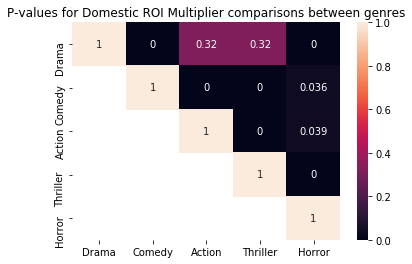

In [234]:
# Creating a diagonal matrix and heatmap
np.fill_diagonal(test.values, 1) # Filling in the diagonal of the matrix
test.fillna(value=np.nan, inplace=True)
mask = test.isnull() # creating a mask that will not be shown in the final image
fig = sns.heatmap(test, mask=mask, annot=True)
fig.set_title("P-values for Domestic ROI Multiplier comparisons between genres", fontsize=12)

The figure is certainly striking, and tells us that most of the time, the genres significantly differ from one another
in terms of their multipliers! 

In [235]:
## Comparing absolute profit between genres
profitcomp_df = pd.DataFrame(index=genres, columns=genres) 

profitcomp_df.loc['Drama', 'Comedy'] = bootstrap_median_diff(drama_df, comedy_df, 'Profit (millions)')[1]
profitcomp_df.loc['Drama', 'Action'] = bootstrap_median_diff(drama_df, action_df, 'Profit (millions)')[1]
profitcomp_df.loc['Drama', 'Thriller'] = bootstrap_median_diff(drama_df, thriller_df, 'Profit (millions)')[1]
profitcomp_df.loc['Drama', 'Horror'] = bootstrap_median_diff(drama_df, horror_df, 'Profit (millions)')[1]
profitcomp_df.loc['Comedy', 'Action'] = bootstrap_median_diff(comedy_df, action_df, 'Profit (millions)')[1]
profitcomp_df.loc['Comedy', 'Thriller'] = bootstrap_median_diff(comedy_df, thriller_df, 'Profit (millions)')[1]
profitcomp_df.loc['Comedy', 'Horror'] = bootstrap_median_diff(comedy_df, horror_df, 'Profit (millions)')[1]
profitcomp_df.loc['Action', 'Thriller'] = bootstrap_median_diff(comedy_df, thriller_df, 'Profit (millions)')[1]
profitcomp_df.loc['Action', 'Horror'] = bootstrap_median_diff(comedy_df, horror_df, 'Profit (millions)')[1]
profitcomp_df.loc['Thriller', 'Horror'] = bootstrap_median_diff(thriller_df, horror_df, 'Profit (millions)')[1]

Text(0.5, 1.0, 'P-values for Profit comparisons between genres')

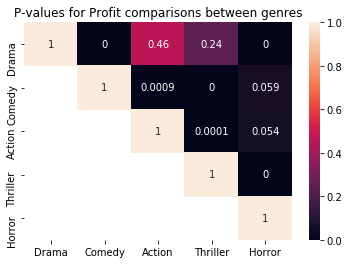

In [236]:
# Creating a diagonal matrix and heatmap
np.fill_diagonal(profitcomp_df.values, 1) # Filling in the diagonal of the matrix
profitcomp_df.fillna(value=np.nan, inplace=True)
mask = profitcomp_df.isnull() # creating a mask that will not be shown in the final image
fig = sns.heatmap(profitcomp_df, mask=mask, annot=True)
fig.set_title("P-values for Profit comparisons between genres", fontsize=12)

If we use profit as the means of comparison, we also tend to notice significant differences between genres, although
it is slightly more nuanced than when we use multipliers. Most of the general patterns still remain, but now we find 
that horror does not significantly differ from comedy or action movies when it comes to amount of profit earned.

More to come in the milestone report!